# 사전 설정 (colab)

In [ ]:
# 필수 라이브러리 설치
# transformers: Hugging Face의 트랜스포머 모델들을 사용하기 위한 라이브러리
# FFmpeg: 비디오/오디오 처리를 위한 도구(코덱처리)
!pip install -U -q transformers
!pip install -q FFmpeg
# !pip install -q mediapipe
!pip install -q ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 79.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.3 MB/s eta 0:00:00


In [ ]:
# Google Drive를 Colab 환경에 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 작업 디렉토리를 헬스케어 해커톤 모델 폴더로 변경
%cd /content/drive/MyDrive/02.git/healthcare-hackathon/model

/content/drive/MyDrive/02.git/healthcare-hackathon/model


## 라이브러리

In [ ]:
# Cell 1: 라이브러리 임포트
import cv2
import torch
from PIL import Image
import time
from transformers import pipeline
import matplotlib.pyplot as plt
from transformers import AutoImageProcessor, AutoModelForImageClassification, ViTImageProcessor, ViTForImageClassification, pipeline
import numpy as np
from ultralytics import YOLO

print("✅ 기본 라이브러리 임포트 완료")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ 기본 라이브러리 임포트 완료


In [ ]:
# Cell 2: 커스텀 모듈 임포트
# 모듈 검색 경로에 fer2013-finetuning 디렉토리 추가
# FER2013 데이터셋 파인튜닝 관련 모듈들을 import하기 위함
import sys
sys.path.append('./fer2013-finetuning')

# 감정 분석 모델 관련 라이브러리 및 모듈 import
import torch  # PyTorch 딥러닝 프레임워크
from models.classifier import create_emotion_classifier  # 감정 분류 모델 생성 함수
from utils.dataset import create_dataloaders  # 데이터로더 생성 유틸리티
from utils.trainer import EmotionTrainer  # 감정 모델 훈련 클래스
from configs.config import Config  # 설정 파일

print("✅ 커스텀 모듈 임포트 완료")


✅ 커스텀 모듈 임포트 완료


In [ ]:
# Cell 3: 경로 및 설정
path_ = '/content/drive/MyDrive/05.share/'

epoch_m, epoch_v = '3', '4'

model_name_mobile = f'model-weights/mobilenet_epoch_{epoch_m}.pth'
model_name_vit = f'model-weights/ViT_epoch_{epoch_v}.pth'

path_vit = path_+model_name_vit
path_mobile = path_+model_name_mobile

print(f"Mobile 모델 경로: {path_mobile}")
print(f"ViT 모델 경로: {path_vit}")


Mobile 모델 경로: /content/drive/MyDrive/05.share/model-weights/mobilenet_epoch_3.pth
ViT 모델 경로: /content/drive/MyDrive/05.share/model-weights/ViT_epoch_4.pth


In [ ]:
# Cell 4: 모바일넷 모델 로드
# 모바일넷 모델 로드
mob_model = create_emotion_classifier()
checkpoint = torch.load('/content/drive/MyDrive/05.share/model-weights/best_model_finetuned.pth', map_location=(Config.DEVICE))
mob_model.load_state_dict(checkpoint)
mob_model.to(Config.DEVICE)

print("✅ 모바일넷 모델 로드 완료")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/679 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/39.2M [00:00<?, ?B/s]

✅ 모바일넷 모델 로드 완료


In [ ]:
# Cell 5: 데이터 다운로드
# Google Drive에서 테스트 비디오 파일 다운로드
file_id = '1Eqa3Ao5QwCRSmcYlEsWvube1nISg8AmV'
!gdown {file_id} -O /content/test_720p_vid.mp4  # 720p 화질의 기존과 다른 영상

# YOLO 가중치 파일
file_id = '1ZpmtGC27LH4gUMHsDEw4eMYBb4csL3o7'
!gdown {file_id} -O /content/yolov12-face.zip
!unzip /content/yolov12-face.zip -d /content/yolov12-face

print("✅ 데이터 다운로드 완료")

Downloading...
From: https://drive.google.com/uc?id=1Eqa3Ao5QwCRSmcYlEsWvube1nISg8AmV
To: /content/test_720p_vid.mp4
100% 2.89M/2.89M [00:00<00:00, 22.0MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1ZpmtGC27LH4gUMHsDEw4eMYBb4csL3o7
From (redirected): https://drive.google.com/uc?id=1ZpmtGC27LH4gUMHsDEw4eMYBb4csL3o7&confirm=t&uuid=def07dd7-a58f-4153-81fe-849f0d910292
To: /content/yolov12-face.zip
100% 109M/109M [00:01<00:00, 67.4MB/s] 
Archive:  /content/yolov12-face.zip
replace /content/yolov12-face/yolov12n-face.pt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/yolov12-face/yolov12l-face.pt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/yolov12-face/yolov12m-face.pt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/yolov12-face/yolov12s-face.pt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
✅ 데이터 다운로드 완료


In [ ]:
# Cell 6: ViT 모델 로드 및 설정
# ViT 모델 로드
processor = ViTImageProcessor.from_pretrained("mo-thecreator/vit-Facial-Expression-Recognition")
emotion_model = ViTForImageClassification.from_pretrained("mo-thecreator/vit-Facial-Expression-Recognition")
emotion_model.load_state_dict(torch.load(path_vit, map_location = (Config.DEVICE)))
emotion_model.eval()
emotion_model.to(Config.DEVICE)

# 파이프라인 및 YOLO 모델 설정
pipe = pipeline("image-classification", model="mo-thecreator/vit-Facial-Expression-Recognition", use_fast=True)
yolo_model = YOLO('/content/yolov12-face/yolov12l-face.pt')  # 얼굴 탐지용 YOLO 모델 파일
device = 'cuda'

# 감정 라벨 매핑 (7개 클래스)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

print("✅ ViT 모델 및 YOLO 로드 완료")

Device set to use cuda:0


✅ ViT 모델 및 YOLO 로드 완료


In [ ]:
# Cell 7: 비디오 정보 확인
# OpenCV를 사용한 비디오 파일 정보 추출
test_vid = '/content/test_720p_vid.mp4'  # 테스트 비디오 파일 경로
cap = cv2.VideoCapture(test_vid)  # 비디오 캡처 객체 생성

# 비디오 속성 정보 가져오기
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))   # 비디오 너비
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) # 비디오 높이
total_frame = cap.get(cv2.CAP_PROP_FRAME_COUNT)  # 총 프레임 수

# 비디오 정보 출력
print('width, height:', width, height)
print('total_frame:', total_frame)

cap.release()

width, height: 720 1280
total_frame: 816.0


In [ ]:
# Cell 8: 감정 예측 함수 정의 (ViT + MobileNet 지원)
def predict_emotion(face_image, model, model_type='vit'):
    """
    얼굴 이미지에서 감정을 예측하는 함수
    Args:
        face_image: 입력 얼굴 이미지 (numpy array)
        model: 추론에 사용할 모델
        model_type: 'vit' 또는 'mobilenet'
    """
    try:
        if model_type.lower() == 'vit':
            # ViT 모델 추론 경로
            # 1. bbox 크롭된 이미지를 1:1 비율로 패딩 (훈련 시와 동일)
            h, w = face_image.shape[:2]
            max_size = max(h, w)

            # 정사각형 패딩
            square_img = np.zeros((max_size, max_size, 3), dtype=np.uint8)
            y_offset = (max_size - h) // 2
            x_offset = (max_size - w) // 2
            square_img[y_offset:y_offset+h, x_offset:x_offset+w] = face_image

            # 2. PIL 이미지로 변환
            pil_image = Image.fromarray(square_img)

            # RGB 모드 확인
            if pil_image.mode != 'RGB':
                pil_image = pil_image.convert('RGB')

            # 3. ViT 전처리 (224x224로 자동 리사이즈)
            inputs = processor(pil_image, return_tensors="pt").to(device)

            # 4. 추론
            with torch.no_grad():
                outputs = model(**inputs)
                predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

            # 5. 상위 2개 결과 반환
            top2_idx = torch.topk(predictions, 2).indices[0]
            top2_scores = torch.topk(predictions, 2).values[0]

            results = []
            for idx, score in zip(top2_idx, top2_scores):
                results.append({
                    'label': emotion_labels[idx.item()],
                    'score': score.item()
                })

        elif model_type.lower() == 'mobilenet':
            # MobileNet 모델 추론 경로
            # 1. 이미지 전처리 (MobileNet용)
            # PIL 이미지로 변환
            pil_image = Image.fromarray(face_image)

            # RGB 모드 확인
            if pil_image.mode != 'RGB':
                pil_image = pil_image.convert('RGB')

            # 2. MobileNet용 전처리 (일반적으로 224x224 리사이즈 + 정규화)
            # 여기서는 Config나 사용자의 전처리 방식에 맞게 조정 필요
            import torchvision.transforms as transforms

            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

            input_tensor = transform(pil_image).unsqueeze(0).to(device)

            # 3. 추론
            model.eval()
            with torch.no_grad():
                outputs = model(input_tensor)
                predictions = torch.nn.functional.softmax(outputs, dim=-1)

            # 4. 상위 2개 결과 반환
            top2_idx = torch.topk(predictions, 2).indices[0]
            top2_scores = torch.topk(predictions, 2).values[0]

            results = []
            for idx, score in zip(top2_idx, top2_scores):
                results.append({
                    'label': emotion_labels[idx.item()],
                    'score': score.item()
                })

        else:
            raise ValueError(f"지원하지 않는 모델 타입: {model_type}. 'vit' 또는 'mobilenet'을 사용하세요.")

        return results

    except Exception as e:
        print(f"감정 예측 오류 ({model_type}): {e}")
        return [{'label': 'Unknown', 'score': 0.0}]

# 사용 예시를 위한 래퍼 함수들
def predict_with_vit(face_image):
    """ViT 모델로 감정 예측"""
    return predict_emotion(face_image, emotion_model, model_type='vit')

def predict_with_mobilenet(face_image):
    """MobileNet 모델로 감정 예측"""
    return predict_emotion(face_image, mob_model, model_type='mobilenet')

print("✅ ViT + MobileNet 지원 감정 예측 함수 정의 완료")
print("사용법:")
print("- ViT: predict_emotion(face_image, emotion_model, 'vit')")
print("- MobileNet: predict_emotion(face_image, mob_model, 'mobilenet')")
print("- 또는 래퍼 함수: predict_with_vit(face_image), predict_with_mobilenet(face_image)")


✅ ViT + MobileNet 지원 감정 예측 함수 정의 완료
사용법:
- ViT: predict_emotion(face_image, emotion_model, 'vit')
- MobileNet: predict_emotion(face_image, mob_model, 'mobilenet')
- 또는 래퍼 함수: predict_with_vit(face_image), predict_with_mobilenet(face_image)


In [ ]:
# Cell 9: 메인 비디오 처리
# 비디오 캡처 열기
cap = cv2.VideoCapture(test_vid)

# 결과를 저장할 리스트
frame_count = 0
frame_emotions = []  # 각 프레임별 감정 정보 저장
result_frames = []
time_st = time.time()

print("🎬 비디오 처리 시작...")

# 비디오의 모든 프레임을 순회하며 얼굴 탐지, 감정 분석 수행
while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        if frame_emotions == []:
            print('breaked')
        else:
            print('ended')
        break

    # n프레임마다 감정 분석 수행
    if frame_count % 100 == 0:
        print(f"처리 중: {frame_count} 프레임...")

        # YOLOv12을 사용하여 얼굴 탐지
        results = yolo_model(frame, verbose=False)

        frame_processed = False
        current_frame_emotions = []  # 현재 프레임의 감정들

        # 감지된 얼굴에 대해 감정 분석
        for result in results:
            boxes = result.boxes
            if boxes is not None and len(boxes) > 0:
                for box in boxes:
                    try:
                        if box.conf[0] > 0.8:
                            x1, y1, x2, y2 = map(int, box.xyxy[0])

                            # YOLO 신뢰도 추출
                            confidence = float(box.conf[0])

                            # 유효한 바운딩 박스인지 확인
                            if x2 > x1 and y2 > y1:
                                # 얼굴 영역 크롭
                                face_crop = frame[y1:y2, x1:x2]

                                # 크롭된 이미지가 유효한지 확인
                                if face_crop.size > 0:
                                    # RGB로 변환 (OpenCV는 BGR이므로)
                                    face_rgb = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)

                                    # 바운딩 박스 그리기
                                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

                                    # 감정 예측 (우리가 훈련한 모델 사용)
                                    emotion_results = predict_emotion(face_rgb, emotion_model, 'vit')

                                    # 상위 2개 감정 저장
                                    # 가중치 적용: 1st = 2배, 2nd = 1배
                                    if len(emotion_results) >= 2:
                                      first_emotion = emotion_results[0]['label']
                                      second_emotion = emotion_results[1]['label']

                                      first_score = emotion_results[0]['score']
                                      second_score = emotion_results[1]['score']

                                      # 신뢰도 차이가 클수록 첫 번째에 더 큰 가중치
                                      score_ratio = first_score / (second_score + 0.01)  # 0으로 나누기 방지
                                      if score_ratio > 2.0:  # 2배 이상 차이나면
                                          current_frame_emotions.extend([first_emotion] * 3)  # 3배 가중치
                                          current_frame_emotions.extend([second_emotion])
                                      else:
                                          current_frame_emotions.extend([first_emotion])
                                          current_frame_emotions.extend([second_emotion])

                                    # 상위 2개 감정 표시
                                    for i, emotion in enumerate(emotion_results[:2]):

                                        # 감정 + YOLO 신뢰도 라벨을 프레임에 표시
                                        emotion_text = f"{i+1}. {emotion['label']}: {emotion['score']:.2f}"
                                        y_pos = y1 - 45 + (i * 20)  # 각 감정을 다른 줄에 표시

                                        cv2.putText(frame, emotion_text, (x1, y_pos),
                                                  cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

                                    # # YOLO 신뢰도 표시
                                    # detection_text = f"Face: {confidence:.2f}"
                                    # cv2.putText(frame, detection_text, (x1, y1-5),
                                    #           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

                                    frame_processed = True

                                    # # pipe로 추론할 때 주석 해제
                                    # emotion_results = pipe(Image.fromarray(face_rgb))

                                    # # 상위 2개 감정 저장 (파이프라인 결과 형식에 맞게)
                                    # for i, emotion in enumerate(emotion_results[:2]):  # 상위 2개만
                                    #     emo_list.append(emotion['label'])
                                    #     frame_processed = True

                                    #     # 감정 라벨을 프레임에 표시
                                    #     emotion_text = f"{i+1}. {emotion['label']}: {emotion['score']:.3f}"
                                    #     y_pos = y1 - 30 + (i * 20)  # 각 감정을 다른 줄에 표시
                                    #     cv2.putText(frame, emotion_text, (x1, y_pos),
                                    #               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

                    except Exception as e:
                        print(f"박스 처리 오류: {e}")
                        continue

        # 얼굴이 감지되고 처리된 경우에만 프레임 저장
        if frame_processed:
            result_frames.append(frame.copy())
            frame_emotions.append(current_frame_emotions)

    frame_count += 1

# 정리
cap.release()
time_end = time.time()
runtime = time_end - time_st

# 통계를 위한 전체 감정 리스트 생성
all_emotions = []
for emotions in frame_emotions:
    all_emotions.extend(emotions)

print(f'✅ 처리 완료!')
print(f'실행시간: {runtime:.2f}초')
print(f'처리된 프레임 수: {len(result_frames)}')
print(f'총 감정 예측 수: {len(all_emotions)}')
if len(all_emotions) > 0:
    unique, counts = np.unique(all_emotions, return_counts=True)
    print(f'감정 분포: {dict(zip(unique, counts))}')
else:
    print('감정 데이터가 없습니다.')


🎬 비디오 처리 시작...
처리 중: 0 프레임...
처리 중: 100 프레임...
처리 중: 200 프레임...
처리 중: 300 프레임...
처리 중: 400 프레임...
처리 중: 500 프레임...
처리 중: 600 프레임...
처리 중: 700 프레임...
처리 중: 800 프레임...
ended
✅ 처리 완료!
실행시간: 3.90초
처리된 프레임 수: 9
총 감정 예측 수: 34
감정 분포: {np.str_('Angry'): np.int64(3), np.str_('Disgust'): np.int64(6), np.str_('Fear'): np.int64(1), np.str_('Happy'): np.int64(4), np.str_('Sad'): np.int64(12), np.str_('Surprise'): np.int64(8)}


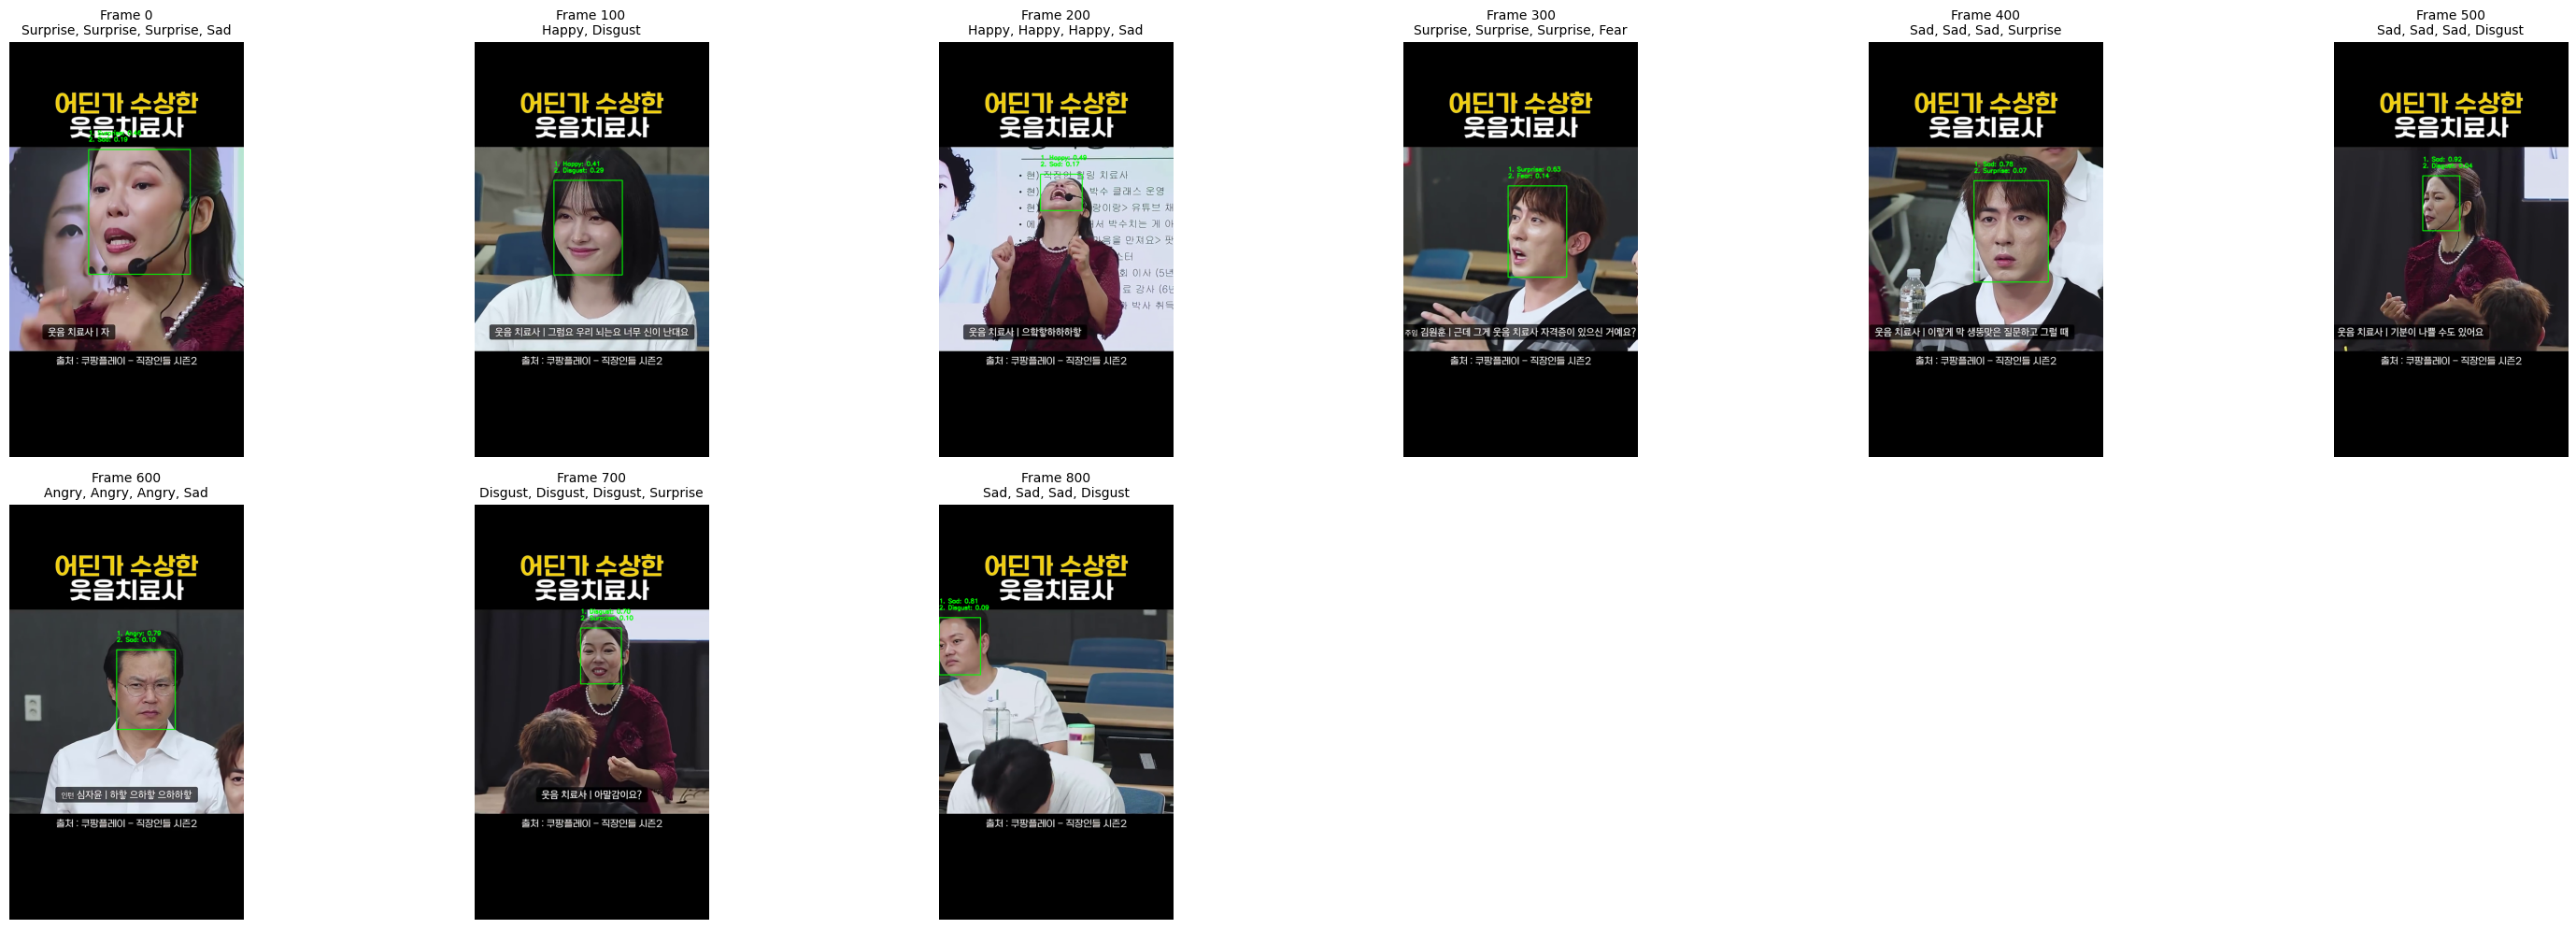

In [ ]:
# 시각화 부분
if len(result_frames) > 0:
    # 실제 저장된 프레임 수에 맞게 서브플롯 조정
    num_frames = min(len(result_frames), 18)  # 최대 18개 (3x6)
    rows = 3
    cols = 6

    fig, axes = plt.subplots(rows, cols, figsize=(30, 15))
    axes = axes.flatten()

    # result_frames의 이미지를 서브플롯에 표시
    for i in range(rows * cols):
        if i < len(result_frames):
            axes[i].imshow(cv2.cvtColor(result_frames[i], cv2.COLOR_BGR2RGB))

            # 해당 프레임의 감정들을 제목으로 표시
            if i < len(frame_emotions):
                emotions_text = ", ".join(frame_emotions[i])
                axes[i].set_title(f'Frame {i*100}\n{emotions_text}', fontsize=10)
            else:
                axes[i].set_title(f'Frame {i*100}\nN/A', fontsize=10)
        else:
            axes[i].set_visible(False)  # 빈 서브플롯 숨기기
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("표시할 프레임이 없습니다.")


In [ ]:
# 감정별 카운트를 저장할 딕셔너리 초기화
emo_map = {
    'Angry': 0,
    'Disgust': 0,
    'Fear': 0,
    'Happy': 0,
    'Neutral': 0,
    'Sad': 0,
    'Surprise': 0
}

# 모든 감정에 대해 카운트를 업데이트하고 이모지와 함께 결과 출력
for emo, count in emo_map.items():
    # 전체 감정 리스트에서 카운트
    emo_map[emo] = all_emotions.count(emo)

    # 각 감정에 해당하는 이모지 설정
    emoji_map = {
        'Angry': '😡',
        'Disgust': '🤢',
        'Fear': '😨',
        'Happy': '😄',
        'Neutral': '😐',
        'Sad': '😭',
        'Surprise': '😮'
    }

    face = emoji_map.get(emo, '❓')

    # 감정별 통계 결과를 이모지와 함께 출력
    print(f'{face}감정: {emo}, ✅등장 횟수: {emo_map[emo]}\n')

# 프레임별 감정 상세 출력
print("\n📋 프레임별 감정 분석 결과:")
for i, emotions in enumerate(frame_emotions):
    print(f"Frame {i*100}: {', '.join(emotions)}")

😡감정: Angry, ✅등장 횟수: 3

🤢감정: Disgust, ✅등장 횟수: 6

😨감정: Fear, ✅등장 횟수: 1

😄감정: Happy, ✅등장 횟수: 4

😐감정: Neutral, ✅등장 횟수: 0

😭감정: Sad, ✅등장 횟수: 12

😮감정: Surprise, ✅등장 횟수: 8


📋 프레임별 감정 분석 결과:
Frame 0: Surprise, Surprise, Surprise, Sad
Frame 100: Happy, Disgust
Frame 200: Happy, Happy, Happy, Sad
Frame 300: Surprise, Surprise, Surprise, Fear
Frame 400: Sad, Sad, Sad, Surprise
Frame 500: Sad, Sad, Sad, Disgust
Frame 600: Angry, Angry, Angry, Sad
Frame 700: Disgust, Disgust, Disgust, Surprise
Frame 800: Sad, Sad, Sad, Disgust


In [ ]:
# Cell 9: 메인 비디오 처리
# 비디오 캡처 열기
cap = cv2.VideoCapture(test_vid)

# 결과를 저장할 리스트
frame_count = 0
frame_emotions = []  # 각 프레임별 감정 정보 저장
result_frames = []
time_st = time.time()

print("🎬 비디오 처리 시작...")

# 비디오의 모든 프레임을 순회하며 얼굴 탐지, 감정 분석 수행
while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        if frame_emotions == []:
            print('breaked')
        else:
            print('ended')
        break

    # n프레임마다 감정 분석 수행
    if frame_count % 100 == 0:
        print(f"처리 중: {frame_count} 프레임...")

        # YOLOv12을 사용하여 얼굴 탐지
        results = yolo_model(frame, verbose=False)

        frame_processed = False
        current_frame_emotions = []  # 현재 프레임의 감정들

        # 감지된 얼굴에 대해 감정 분석
        for result in results:
            boxes = result.boxes
            if boxes is not None and len(boxes) > 0:
                for box in boxes:
                    try:
                        if box.conf[0] > 0.8:
                            x1, y1, x2, y2 = map(int, box.xyxy[0])

                            # YOLO 신뢰도 추출
                            confidence = float(box.conf[0])

                            # 유효한 바운딩 박스인지 확인
                            if x2 > x1 and y2 > y1:
                                # 얼굴 영역 크롭
                                face_crop = frame[y1:y2, x1:x2]

                                # 크롭된 이미지가 유효한지 확인
                                if face_crop.size > 0:
                                    # RGB로 변환 (OpenCV는 BGR이므로)
                                    face_rgb = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)

                                    # 감정 예측 (우리가 훈련한 모델 사용)
                                    emotion_results = predict_emotion(face_rgb, emotion_model, 'vit')

                                    # 상위 2개 감정 저장
                                    # 가중치 적용: 1st = 2배, 2nd = 1배
                                    if len(emotion_results) >= 2:
                                      first_emotion = emotion_results[0]['label']
                                      second_emotion = emotion_results[1]['label']

                                      first_score = emotion_results[0]['score']
                                      second_score = emotion_results[1]['score']

                                      # 신뢰도 차이가 클수록 첫 번째에 더 큰 가중치
                                      score_ratio = first_score / (second_score + 0.01)  # 0으로 나누기 방지
                                      if score_ratio > 2.0:  # 2배 이상 차이나면
                                          current_frame_emotions.extend([first_emotion] * 3)  # 3배 가중치
                                          current_frame_emotions.extend([second_emotion])
                                      else:
                                          current_frame_emotions.extend([first_emotion])
                                          current_frame_emotions.extend([second_emotion])



                    except Exception as e:
                        print(f"박스 처리 오류: {e}")
                        continue

        # 얼굴이 감지되고 처리된 경우에만 프레임 저장
        if frame_processed:
            result_frames.append(frame.copy())
            frame_emotions.append(current_frame_emotions)

    frame_count += 1

# 정리
cap.release()
time_end = time.time()
runtime = time_end - time_st

# 통계를 위한 전체 감정 리스트 생성
all_emotions = []
for emotions in frame_emotions:
    all_emotions.extend(emotions)


# 감정별 카운트를 저장할 딕셔너리 초기화
emo_map = {
    'Angry': 0,
    'Disgust': 0,
    'Fear': 0,
    'Happy': 0,
    'Neutral': 0,
    'Sad': 0,
    'Surprise': 0
}

# 모든 감정에 대해 카운트를 업데이트하고 이모지와 함께 결과 출력
for emo, count in emo_map.items():
    # 전체 감정 리스트에서 카운트
    emo_map[emo] = all_emotions.count(emo)

    # 각 감정에 해당하는 이모지 설정
    emoji_map = {
        'Angry': '😡',
        'Disgust': '🤢',
        'Fear': '😨',
        'Happy': '😄',
        'Neutral': '😐',
        'Sad': '😭',
        'Surprise': '😮'
    }

    face = emoji_map.get(emo, '❓')

    # 감정별 통계 결과를 이모지와 함께 출력
    print(f'{face}감정: {emo}, ✅등장 횟수: {emo_map[emo]}\n')

# 프레임별 감정 상세 출력
print("\n📋 프레임별 감정 분석 결과:")
for i, emotions in enumerate(frame_emotions):
    print(f"Frame {i*100}: {', '.join(emotions)}")
